# Tutorial 2: Matrices

**Week 0, Day 3: Linear Algebra**

**By Neuromatch Academy**

__Content creators:__ Ella Batty

__Content reviewers:__ Keith van Antwerp, Aderogba Bayo, Anoop Kulkarni, Pooya Pakarian

__Production editors:__ Siddharth Suresh, Ella Batty  

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

*Estimated timing of tutorial: 1 hour, 35 minutes*

During today, we will learn the basics of linear algebra, focusing on the topics that underlie the material on future days in the NMA Computational Neuroscience course. In this tutorial, we focus on matrices: their definition, their properties & operations, and especially on a geometrical intuition of them.

By the end of this tutorial, you will be able to :
* Explain matrices as a linear transformation and relate matrix properties to properties of that linear transformation
*  Perform matrix multiplication by hand
*  Define what eigenvalues/eigenvectors are




**Code Credit:**

Some elements of this problem set are from or inspired by https://openedx.seas.gwu.edu/courses/course-v1:GW+EngComp4+2019/about. In particular, we are using their `plot_linear_transformation` and `plot_linear_transformations` functions.

**License**:

Code under BSD 3-Clause License © 2019 Lorena A. Barba, Tingyu Wang. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

---
# Setup

In [1]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch-precourse",
            "user_key": "8zxfvwxw",
        },
    ).render()


feedback_prefix = "W0D3_T2"


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import ipywidgets as widgets  # interactive display
from ipywidgets import fixed
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [4]:
# @title Plotting functions
import numpy
from numpy.linalg import inv, eig
from math import ceil
from matplotlib import pyplot, ticker, get_backend, rc
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle

_int_backends = ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg',
                 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo',
                 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo']
_backend = get_backend()   # get current backend name

# shrink figsize and fontsize when using %matplotlib notebook
if _backend in _int_backends:
  fontsize = 4
  fig_scale = 0.75
else:
  fontsize = 5
  fig_scale = 1

grey = '#808080'
gold = '#cab18c'        # x-axis grid
lightblue = '#0096d6'   # y-axis grid
green = '#008367'       # x-axis basis vector
red = '#E31937'         # y-axis basis vector
darkblue = '#004065'

pink, yellow, orange, purple, brown = '#ef7b9d', '#fbd349', '#ffa500', '#a35cff', '#731d1d'

quiver_params = {'angles': 'xy',
                 'scale_units': 'xy',
                 'scale': 1,
                 'width': 0.012}

grid_params = {'linewidth': 0.5,
               'alpha': 0.8}

def set_rc(func):
  def wrapper(*args, **kwargs):
    rc('font', family='serif', size=fontsize)
    rc('figure', dpi=200)
    rc('axes', axisbelow=True, titlesize=5)
    rc('lines', linewidth=1)
    func(*args, **kwargs)
  return wrapper

@set_rc
def plot_vector(vectors, tails=None):
  ''' Draw 2d vectors based on the values of the vectors and the position of their tails.

  Parameters
  ----------
  vectors : list.
    List of 2-element array-like structures, each represents a 2d vector.

  tails : list, optional.
    List of 2-element array-like structures, each represents the coordinates of the tail
    of the corresponding vector in vectors. If None (default), all tails are set at the
    origin (0,0). If len(tails) is 1, all tails are set at the same position. Otherwise,
    vectors and tails must have the same length.

  Examples
  --------
  >>> v = [(1, 3), (3, 3), (4, 6)]
  >>> plot_vector(v)      # draw 3 vectors with their tails at origin
  >>> t = [numpy.array((2, 2))]
  >>> plot_vector(v, t)   # draw 3 vectors with their tails at (2,2)
  >>> t = [[3, 2], [-1, -2], [3, 5]]
  >>> plot_vector(v, t)   # draw 3 vectors with 3 different tails

  '''
  vectors = numpy.array(vectors)
  assert vectors.shape[1] == 2, "Each vector should have 2 elements."
  if tails is not None:
    tails = numpy.array(tails)
    assert tails.shape[1] == 2, "Each tail should have 2 elements."
  else:
    tails = numpy.zeros_like(vectors)

  # tile vectors or tails array if needed
  nvectors = vectors.shape[0]
  ntails = tails.shape[0]
  if nvectors == 1 and ntails > 1:
    vectors = numpy.tile(vectors, (ntails, 1))
  elif ntails == 1 and nvectors > 1:
    tails = numpy.tile(tails, (nvectors, 1))
  else:
    assert tails.shape == vectors.shape, "vectors and tail must have a same shape"

  # calculate xlimit & ylimit
  heads = tails + vectors
  limit = numpy.max(numpy.abs(numpy.hstack((tails, heads))))
  limit = numpy.ceil(limit * 1.2)   # add some margins

  figsize = numpy.array([2,2]) * fig_scale
  figure, axis = pyplot.subplots(figsize=figsize)
  axis.quiver(tails[:,0], tails[:,1], vectors[:,0], vectors[:,1], color=darkblue,
                  angles='xy', scale_units='xy', scale=1)
  axis.set_xlim([-limit, limit])
  axis.set_ylim([-limit, limit])
  axis.set_aspect('equal')

  # if xticks and yticks of grid do not match, choose the finer one
  xticks = axis.get_xticks()
  yticks = axis.get_yticks()
  dx = xticks[1] - xticks[0]
  dy = yticks[1] - yticks[0]
  base = max(int(min(dx, dy)), 1)   # grid interval is always an integer
  loc = ticker.MultipleLocator(base=base)
  axis.xaxis.set_major_locator(loc)
  axis.yaxis.set_major_locator(loc)
  axis.grid(True, **grid_params)

  # show x-y axis in the center, hide frames
  axis.spines['left'].set_position('center')
  axis.spines['bottom'].set_position('center')
  axis.spines['right'].set_color('none')
  axis.spines['top'].set_color('none')

@set_rc
def plot_transformation_helper(axis, matrix, *vectors, unit_vector=True, unit_circle=False, title=None):
  """ A helper function to plot the linear transformation defined by a 2x2 matrix.

  Parameters
  ----------
  axis : class matplotlib.axes.Axes.
    The axes to plot on.

  matrix : class numpy.ndarray.
    The 2x2 matrix to visualize.

  *vectors : class numpy.ndarray.
    The vector(s) to plot along with the linear transformation. Each array denotes a vector's
    coordinates before the transformation and must have a shape of (2,). Accept any number of vectors.

  unit_vector : bool, optional.
    Whether to plot unit vectors of the standard basis, default to True.

  unit_circle: bool, optional.
    Whether to plot unit circle, default to False.

  title: str, optional.
    Title of the plot.

  """
  assert matrix.shape == (2,2), "the input matrix must have a shape of (2,2)"
  grid_range = 20
  x = numpy.arange(-grid_range, grid_range+1)
  X_, Y_ = numpy.meshgrid(x,x)
  I = matrix[:,0]
  J = matrix[:,1]
  X = I[0]*X_ + J[0]*Y_
  Y = I[1]*X_ + J[1]*Y_
  origin = numpy.zeros(1)

  # draw grid lines
  for i in range(x.size):
    axis.plot(X[i,:], Y[i,:], c=gold, **grid_params)
    axis.plot(X[:,i], Y[:,i], c=lightblue, **grid_params)

  # draw (transformed) unit vectors
  if unit_vector:
    axis.quiver(origin, origin, [I[0]], [I[1]], color=green, **quiver_params)
    axis.quiver(origin, origin, [J[0]], [J[1]], color=red, **quiver_params)

  # draw optional vectors
  color_cycle = cycle([pink, darkblue, orange, purple, brown])
  if vectors:
    for vector in vectors:
      color = next(color_cycle)
      vector_ = matrix @ vector.reshape(-1,1)
      axis.quiver(origin, origin, [vector_[0]], [vector_[1]], color=color, **quiver_params)

  # draw optional unit circle
  if unit_circle:
    alpha =  numpy.linspace(0, 2*numpy.pi, 41)
    circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))
    circle_trans = matrix @ circle
    axis.plot(circle_trans[0], circle_trans[1], color=red, lw=0.8)

  # hide frames, set xlimit & ylimit, set title
  limit = 4
  axis.spines['left'].set_position('center')
  axis.spines['bottom'].set_position('center')
  axis.spines['left'].set_linewidth(0.3)
  axis.spines['bottom'].set_linewidth(0.3)
  axis.spines['right'].set_color('none')
  axis.spines['top'].set_color('none')
  axis.set_xlim([-limit, limit])
  axis.set_ylim([-limit, limit])
  if title is not None:
    axis.set_title(title)

@set_rc
def plot_linear_transformation(matrix, *vectors, name = None, unit_vector=True, unit_circle=False):
  """ Plot the linear transformation defined by a 2x2 matrix using the helper
  function plot_transformation_helper(). It will create 2 subplots to visualize some
  vectors before and after the transformation.

  Parameters
  ----------
  matrix : class numpy.ndarray.
    The 2x2 matrix to visualize.

  *vectors : class numpy.ndarray.
    The vector(s) to plot along with the linear transformation. Each array denotes a vector's
    coordinates before the transformation and must have a shape of (2,). Accept any number of vectors.

  unit_vector : bool, optional.
    Whether to plot unit vectors of the standard basis, default to True.

  unit_circle: bool, optional.
    Whether to plot unit circle, default to False.

  """
  figsize = numpy.array([4,2]) * fig_scale
  figure, (axis1, axis2) = pyplot.subplots(1, 2, figsize=figsize)
  plot_transformation_helper(axis1, numpy.identity(2), *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='Before transformation')
  plot_transformation_helper(axis2, matrix, *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='After transformation')
  if name is not None:
    figure.suptitle(f'Population {name}')


def plot_eig_vec_transform(W):
  classic = 'k'
  vec_names = ['a', 'b','c','d','e','f','g', 'h']

  _, vecs = np.linalg.eig(W)
  vecs = vecs.T

  fig, axes = plt.subplots(1, 2, figsize=(2, 1))
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

  for i in range(2):
    axes[i].set(xlim=[-3.5, 3.5], ylim=[-3.5,3.5])
    axes[i].axis('Off')
    axes[i].plot([0, 0], [-3.5, 3.5], classic, alpha=.4)
    axes[i].plot([-3.5, 3.5], [0, 0], classic, alpha=.4)

  for i_vec, vec in enumerate(vecs):
    axes[0].arrow(0, 0, vec[0], vec[1], head_width=.2, facecolor=colors[i_vec], edgecolor=colors[i_vec], length_includes_head=True)
    axes[0].annotate(vec_names[i_vec], xy=(vec[0]+np.sign(vec[0])*.15, vec[1]+np.sign(vec[1])*.15), color=colors[i_vec])

    transformed_vec = np.matmul(W, vec)
    axes[1].arrow(0, 0, transformed_vec[0], transformed_vec[1], head_width=.2, facecolor=colors[i_vec], edgecolor=colors[i_vec], length_includes_head=True)
    axes[1].annotate(vec_names[i_vec], xy=(transformed_vec[0]+np.sign(transformed_vec[0])*.15, transformed_vec[1]+np.sign(transformed_vec[1])*.15), color=colors[i_vec])

  axes[0].set_title('Before')
  axes[1].set_title('After')

---

# Section 1: Intro to matrices

## Section 1.1: Matrices to solve systems of equations

In [ ]:
# @title Video 1: Systems of Equations
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '3ecnOrMEh00'), ('Bilibili', 'BV1Aq4y1x7hf')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Systems_of_Equations_Video")

This video covers using a matrix to solve a linear system of equations.

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

In a variety of contexts, we may encounter systems of linear equations like this one:

\begin{align}
3x_1 + 2x_2 + x_3 &= y_1 \\
7x_1 + x_2 + 2x_3 &= y_2 \\
x_1 - x_2  - 2x_3 &= y_3
\end{align}

We may know all the $x$'s and want to solve for $y$'s, or we may know the $y$'s and want to solve for the $x$'s. We can solve this in several different ways but one especially appealing way is to cast it as a matrix-vector equation:

\begin{equation}
\mathbf{W}\mathbf{x} = \mathbf{y}
\end{equation}

where

\begin{equation}
\mathbf{W} = \begin{bmatrix} 3 & 2 & 1 \\ 7 & 1 & 2 \\ 1 &-1 &-2 \end{bmatrix},
\mathbf{x} = \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix},
\mathbf{y} = \begin{bmatrix} y_1 \\ y_2 \\ y_3 \end{bmatrix}\\
\end{equation}

If we know $\mathbf{W}$ and $\mathbf{x}$, we can solve for $\mathbf{y}$ using matrix-vector multiplication. Each row of $\mathbf{y}$ is computed as the dot product of the equivalent row of $\mathbf{W}$ and $\mathbf{x}$.

If we know $\mathbf{W}$ and $\mathbf{y}$, we can sometimes solve for $\mathbf{x}$ by using the inverse of $\mathbf{W}$:

\begin{equation}
\mathbf{x} = W^{-1}\mathbf{y}
\end{equation}

The reason this only sometimes works will be dived into later in this tutorial!
</details>

### Coding Exercise 1.1: Understanding neural transformations

We will look at a group of 2 LGN neurons which get input from 2 retinal neurons: we will call the population of LGN neurons population $p$. Below, we have the system of linear equations that dictates the neuron models for each population. $r_1$ and $r_2$ correspond to the retinal neural activities (of neuron 1 and 2). $g_{p_1}$ and  $g_{p_2}$ correspond to the responses of the LGN neurons 1 and 2 in population $p$.

\begin{align}
r_1 + 3r_2 &= g_{p_1} \\
2r_1 + r_2 &= g_{p_2}
\end{align}

<br>

1) Cast each equation (i.e., $g_{p_1}$ and $g_{p_2}$) as a matrix-vector multiplication:

\begin{equation}
\mathbf{g}_p = \mathbf{P}\mathbf{r}
\end{equation}

where $P$ is the weight matrix to population $p$.

2) Let's say we only recorded from the LGN cells (and know the weight matrix) and are trying to figure out how the retinal cells responded. Solve the matrix equation for the given LGN activities:

\begin{equation}
\mathbf{g}_p =
\begin{bmatrix}
16 \\
7
\end{bmatrix}
\end{equation}

<br>

**Note:** In Python, we can use the `@` operator for matrix/vector multiplications. We can also use the NumPy [`np.dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html#numpy.dot), [`np.matmul`](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html). See the documentation for their differences.

In [6]:
# Create P (using np array)
P = np.array([[1, 3], [2, 1]])

# Create g_p (using np array)
g_p = np.array([16, 7])

# Solve for r (using np.linalg.inv)
r = np.linalg.inv(P) @ g_p

# Print r
print(r)

[1. 5.]


You should see the output `[1, 5]`.

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D3_LinearAlgebra/solutions/W0D3_Tutorial2_Solution_2fa7cf85.py)



You can recover how the retinal neurons respond given the weight matrix and LGN responses! You have solved the system of equations using matrices. We can't always do this though: let's say we have a different group of 2 LGN neurons -  population q - with the following weight matrix from the retinal neurons.

\begin{equation}Q =
\begin{bmatrix}
4 & 1 \\
8 & 2
\end{bmatrix}
\end{equation}

As you can see if you uncomment and run the next code cell, we get an error if we try to invert this matrix to solve the equation. We'll find out more about this in the next sections.

In [7]:
g_q = np.array([16, 7])
Q = np.array([[4, 1], [8, 2]])

print(np.linalg.inv(Q) @ g_q)

LinAlgError: Singular matrix

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Understanding_neural_transformations_exercise")

## Section 1.2: Matrices as linear transformations

*Estimated timing to here from start of tutorial: 20 min*

In [ ]:
# @title Video 2: Linear Transformations
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'N6UUV9tVIr8'), ('Bilibili', 'BV1KB4y1T7zM')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Linear_transformations_Video")

Matrices can be thought of as enacting linear transformations. When multiplied with a vector, they transform it into another vector. In fact, they are transforming a grid of space in a linear manner: the origin stays in place and grid lines remain straight, parallel, and evenly spaced.


### Coding Exercise 1.2: Creating matrices for transformations

Come up with a matrix $A$ for which the corresponding linear transformation is reflection through the $y$ axis (flipping across the $y$ axis). For example, $\mathbf{x} = \begin{bmatrix}
2 \\
6  \\
\end{bmatrix}$ should become $\mathbf{b} = \begin{bmatrix}
-2 \\
6  \\
\end{bmatrix}$ when multiplied with $A$.


**Remember to think about where your basis vectors should end up! Then your matrix consists of the transformed basis vectors. Drawing out what you want to happen can help**

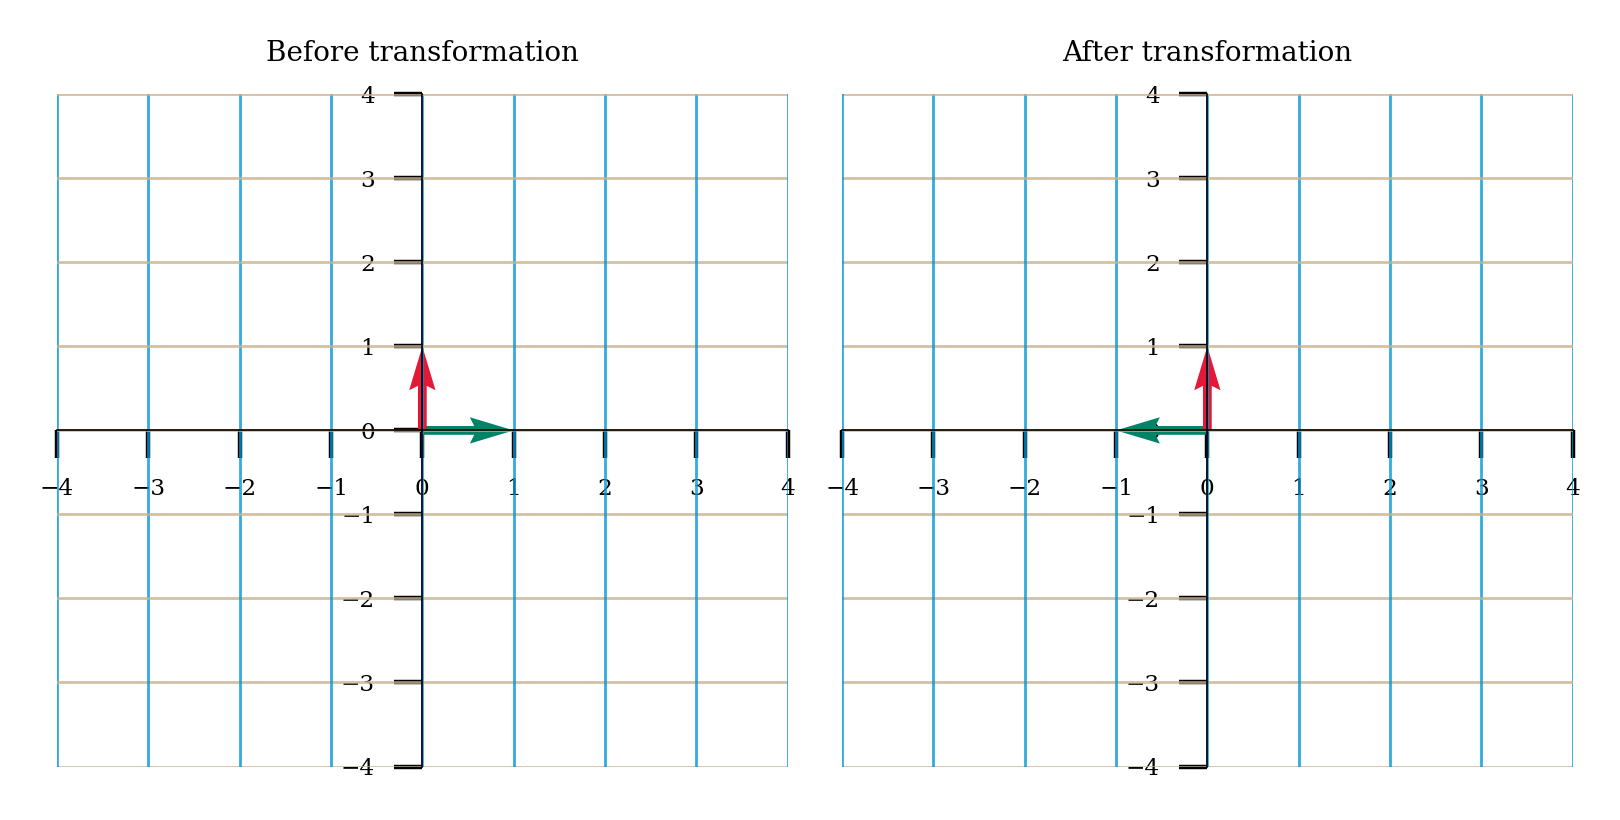

In [8]:
A = np.array([[-1, 0], [0, 1]])

# Uncomment to visualize transformation
plot_linear_transformation(A)

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D3_LinearAlgebra/solutions/W0D3_Tutorial2_Solution_a86560cc.py)

*Example output:*

<img alt='Solution hint' align='left' width=324.0 height=164.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/precourse/main/tutorials/W0D3_LinearAlgebra/static/W0D3_Tutorial2_Solution_a86560cc_0.png>



Come up with a matrix $A$ for which the corresponding linear transformation is projecting onto the $x$ axis. For example, $\bar{x} = \begin{bmatrix}
2 \\
3  \\
\end{bmatrix}$ should become $\bar{b} = \begin{bmatrix}
2 \\
0  \\
\end{bmatrix}$ when multiplied with $A$.

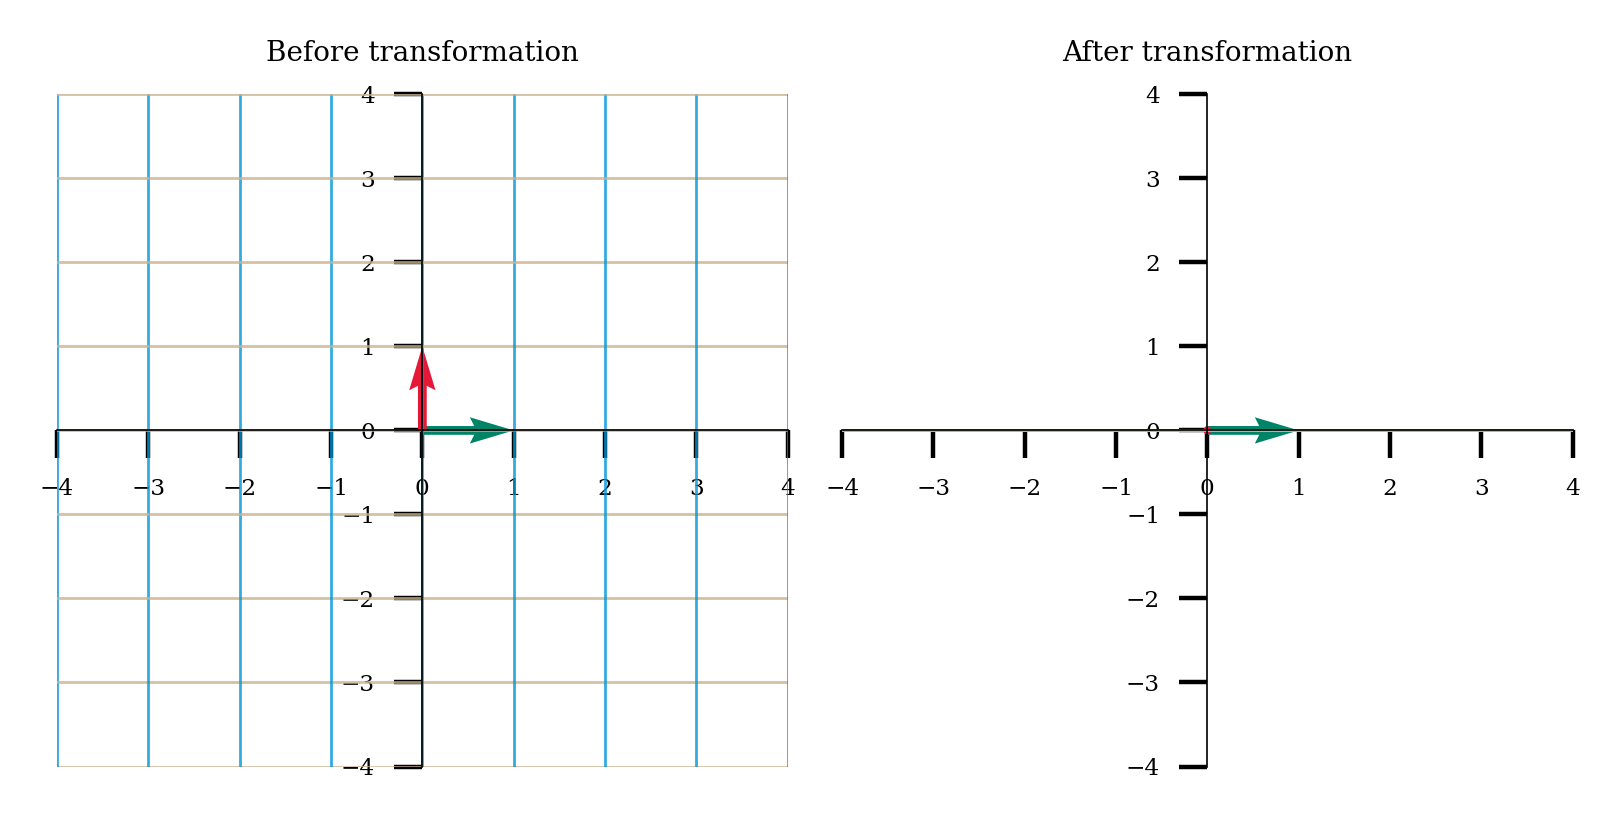

In [10]:
A = np.array([[1, 0], [0, 0]])

# Uncomment to visualize transformation
plot_linear_transformation(A)

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D3_LinearAlgebra/solutions/W0D3_Tutorial2_Solution_8d909295.py)

*Example output:*

<img alt='Solution hint' align='left' width=324.0 height=164.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/precourse/main/tutorials/W0D3_LinearAlgebra/static/W0D3_Tutorial2_Solution_8d909295_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Creating_matrices_for_transformations_Exercise")

## Section 1.3: Rank & Null Space

*Estimated timing to here from start of tutorial: 35 min*

In [ ]:
# @title Video 3: Rank & Null Space
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'ay2p5rgkMcY'), ('Bilibili', 'BV1vw411R7eA')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Rank_&_Null_Space_Video")

This video covers properties of matrices, such as range, rank, and null space, in the context of matrices enacting a linear transformation.

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

Square matrices always result in vectors with the same dimensions (number of components) but can alter the dimensionality of the transformed space. Let's say you have a $3 \times 3$ matrix. You will transform from 3-dimensional vectors to 3-dimensional vectors. You will often be transforming from all of 3D space to all of 3D space. However, this isn't always the case! You could have a $3 \times 3$ matrix that always results in a vector that lies along a 2D plane through 3D space. This matrix would be transforming from a 3 dimensional vector space (all of $\mathbb{R}^3$) to a 2 dimensional vector space (the 2D plane).

Matrices that aren't square are enacting transformations that change the dimensionality of the vectors. If you have a $4 \times 5$ matrix, you are transforming 5-dimensional vectors to 4-dimensional vectors. Similarly, if you have a $4 \times 2$ matrix, you are transforming from 4-dimensional vectors to 2-dimensional vectors.

The **range of a matrix** is the set of all possible vectors it can lead to after a transformation. The **rank of a matrix** is the dimensionality of the range.

Sometimes, a matrix will transform a non-zero vector into a zero vector (the origin). The **null space** of a matrix is the set of all vectors that will be transformed into the origin.
</details>

### Think! 1.3: Neural coding

Let's return to the setup of the previous coding exercise: we have two populations of LGN neurons, p and q, responding to retinal neurons. Visualize the linear transformations of these matrices by running the next code cell. Then discuss the following questions:

1) What are the ranks of weight matrix $P$ and $Q$?

2) What does the null space of these matrices correspond to in our neuroscience setting? **Advanced:** What do you think the dimensionality of the null space is for $P$ and $Q$?

3) What is the intrinsic dimensionality of the population of neural responses in population p? How about in q? The intrinsic dimensionality is the minimal number of dimensions required for a complete representation of the data.

4) If we wanted to decode retinal neural activity from the LGN activities, would we always be able to completely recover the retinal activity when looking at population p? How about population q? What does this tell us about the information loss of the neural processing?

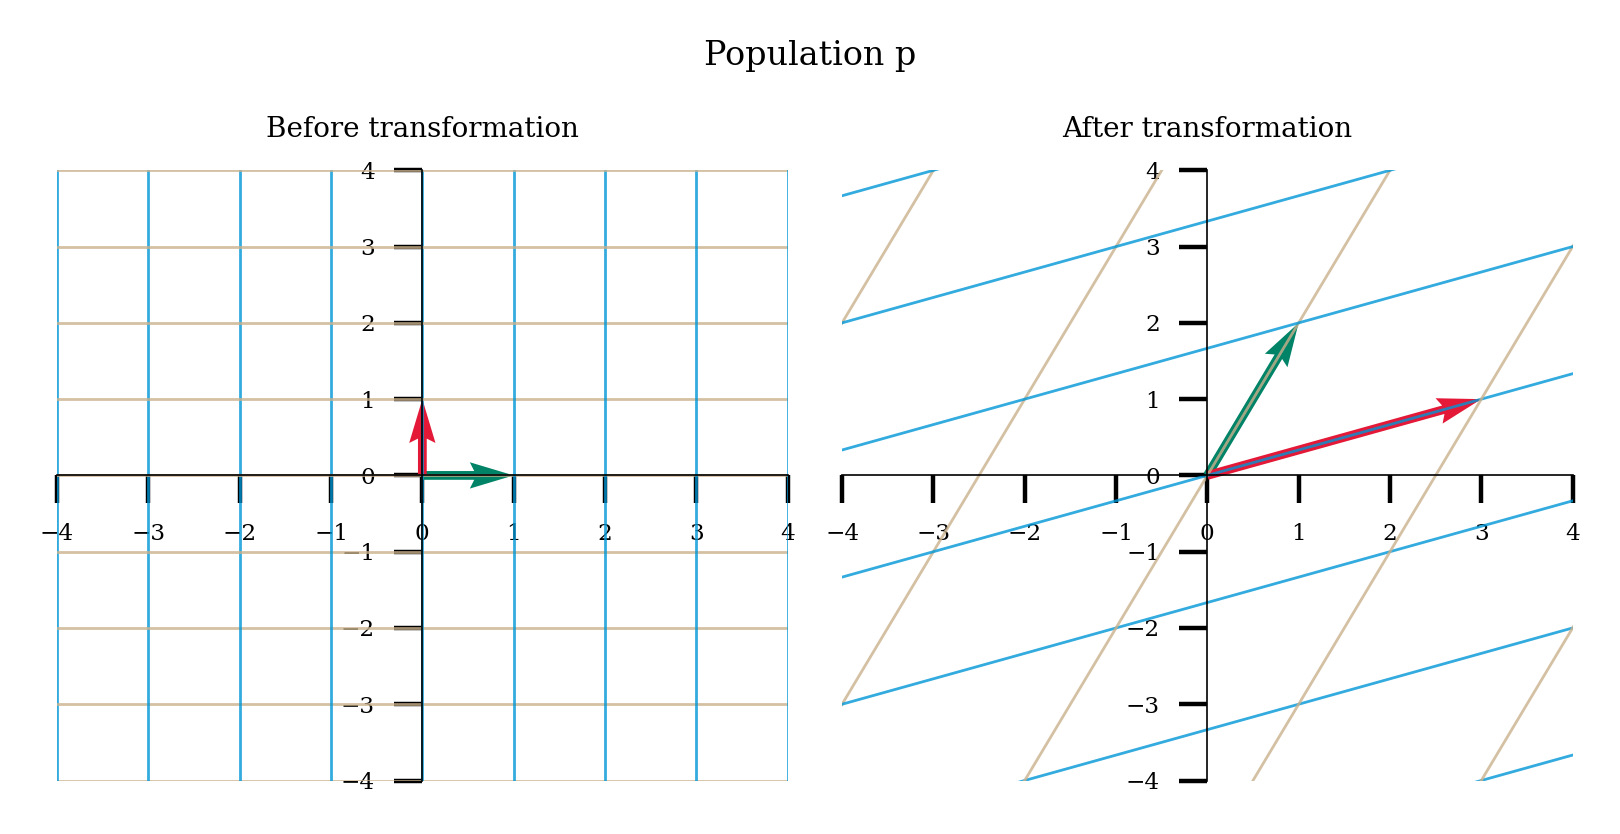

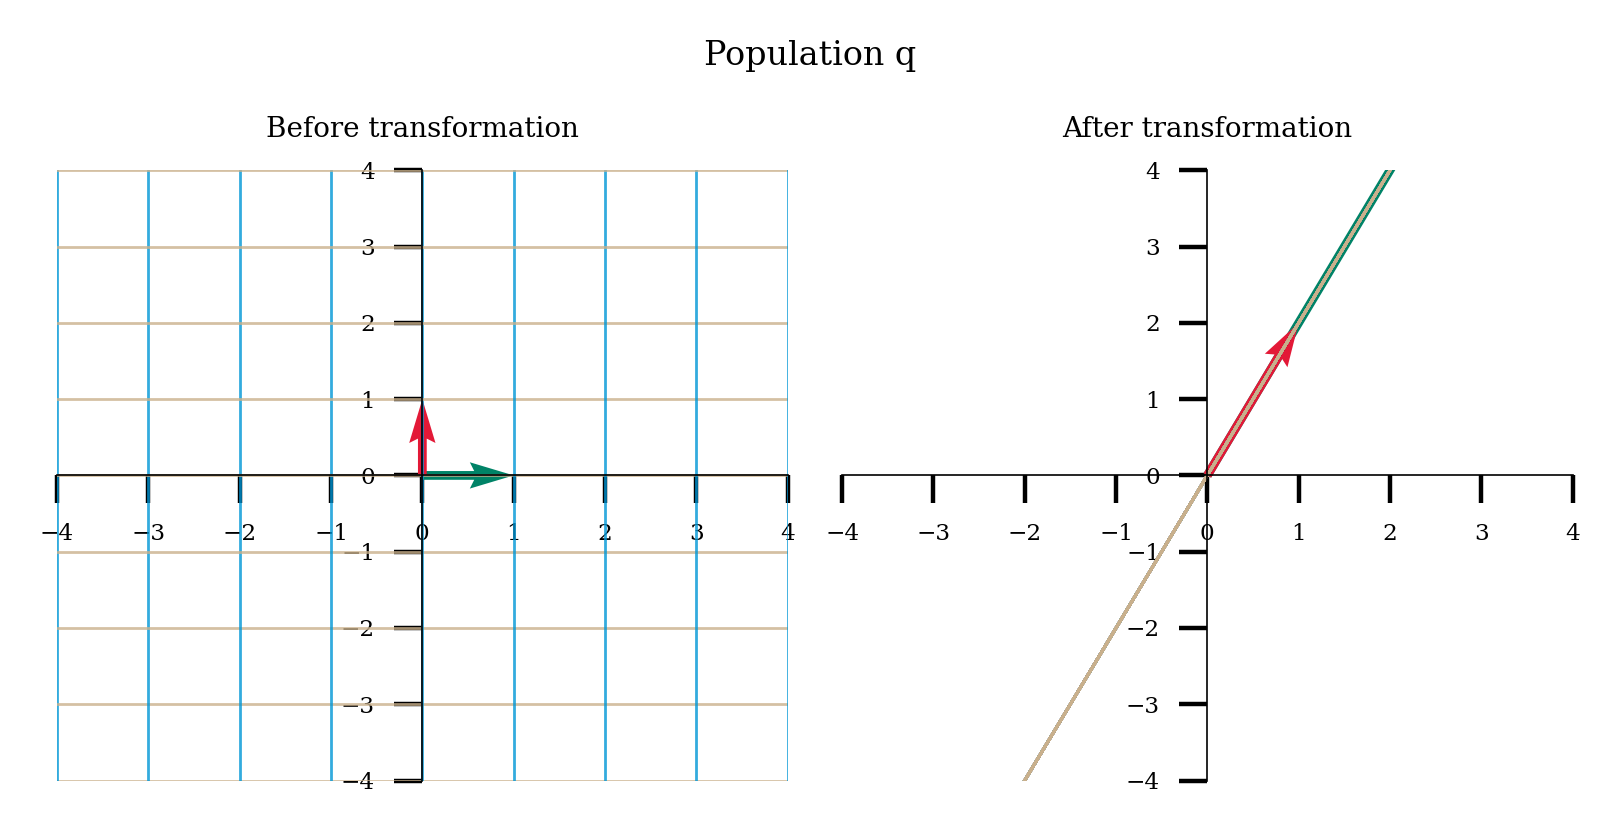

In [11]:
# @markdown Execute to visualize linear transformations
P = np.array([[1, 3], [2, 1]])
plot_linear_transformation(P, name = 'p')

Q = np.array([[4, 1], [8, 2]])
plot_linear_transformation(Q, name = 'q')

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D3_LinearAlgebra/solutions/W0D3_Tutorial2_Solution_4135b6b6.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Neural_coding_Discussion")

---
# Section 2: Eigenvalues & Eigenvectors

*Estimated timing to here from start of tutorial: 65 min*

In [ ]:
# @title Video 4: Eigenstuff
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'l-c7ptT7znM'), ('Bilibili', 'BV1KK4y1M7Ez')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Eigenstuff_Video")

This video covers eigenvalues and eigenvectors.

Eigenvectors $\mathbf{v}$ of a matrix $\mathbf{W}$ are vectors that, when multipled by the matrix, equal a scalar multiple of themselves. That scalar multiple is the corresponding eigenvalue $\lambda$.

\begin{equation}
\mathbf{W}\mathbf{v} = \lambda\mathbf{v}
\end{equation}

If we have one eigenvector for a matrix, we technically have an infinite amount: every vector along the span of that eigenvector is also an eigenvector. So, we often use the unit vector in that direction to summarize all the eigenvectors along that line.

We can find the eigenvalues and eigenvectors of a matrix in numpy using `np.linalg.eig`.

## Think! 2: Identifying transformations from eigenvectors

Earlier, we learned how to think about linear transformations in terms of where the standard basis vectors end up. We can also think about them in terms of eigenvectors.

Just by looking at eigenvectors before and after a transformation, can you describe what the transformation is in words? Try for each of the two plots below.

Note that I show an eigenvector for every eigenvalue. The $x/y$ limits do not change in before vs after (so eigenvectors are showed scaled by the eigenvalues).

Here are some transformation words to jog your memory and guide discussion: contraction, expansion, horizontal vs vertical, projection onto an axis, reflection, and rotation.

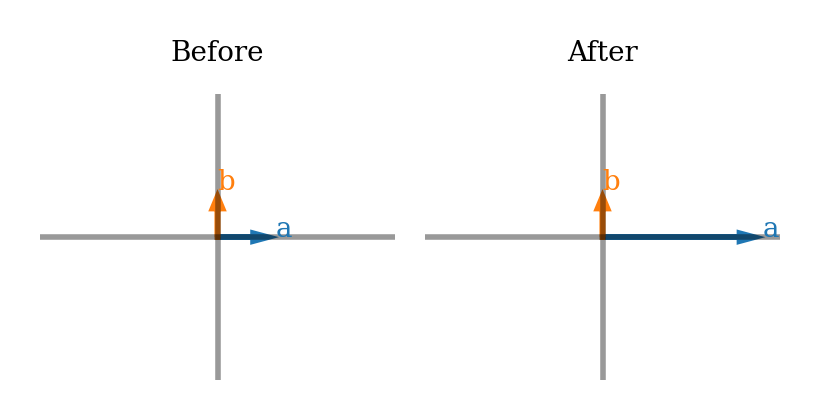

In [12]:
# @title
# @markdown Execute this cell to visualize vectors

W = np.array([[3, 0], [0, 1]])
plot_eig_vec_transform(W)

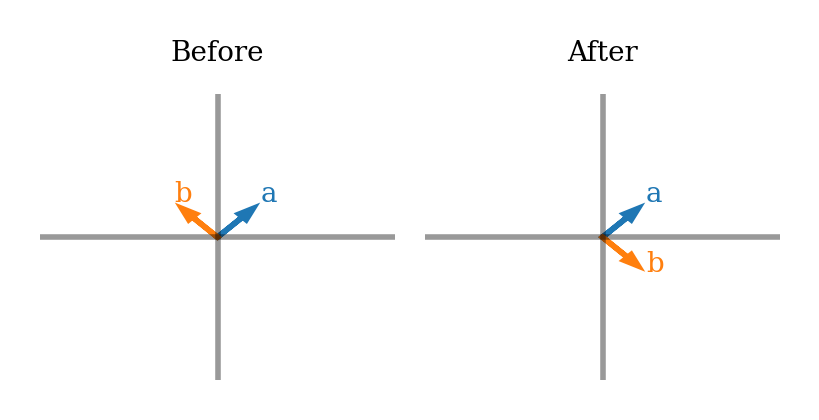

In [13]:
# @title
# @markdown Execute this cell to visualize vectors

W = np.array([[0, 1], [1, 0]])
plot_eig_vec_transform(W)

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D3_LinearAlgebra/solutions/W0D3_Tutorial2_Solution_f946adb3.py)



As we saw above, looking at how just the eigenvectors change after a transformation can be very informative about what that transformation was.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Identifying_transformations_from_eigenvectors_Discussion")

---
# Section 3: Matrix multiplication

*Estimated timing to here from start of tutorial: 80 min*




In [ ]:
# @title Video 5: Matrix Multiplication
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'OFyWfegC9Cs'), ('Bilibili', 'BV1Rb4y1C7cE')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Matrix_Multiplication_Video")

We sometimes want to multiple two matrices together, instead of a matrix with a vector. Let's say we're multiplying matrices $\mathbf{A}$ and $\mathbf{B}$ to get $\mathbf{C}$:

\begin{equation}
\mathbf{C} = \mathbf{A}\mathbf{B}\text{.}
\end{equation}

We take the dot product of each row of A with each column of B. The resulting scalar is placed in the element of $\mathbf{C}$ that is the same row (as the row in A) and column (as the column in B). So the element of $\mathbf{C}$ at row 4 and column 2 is the dot product of the 4th row of $\mathbf{A}$ and the 2nd column of $\mathbf{B}$. We can write this in a formula as:

\begin{equation}
\mathbf{C}_{\text{row i, column j}} = \mathbf{A}_{\text{row i}} \cdot \mathbf{B}_{\text{column j}}
\end{equation}

## Exercise 2: Computation corner

Break out the pen and paper - it's critical to implement matrix multiplication yourself to fully understand how it works.

Let's say we have 3 retina neurons and 2 LGN neurons. The weight matrix, $W$, between the retina and LGN neurons is:

\begin{equation}
W =
\begin{bmatrix}
3 &  2 & 1 \\
1 & 2 & 7
\end{bmatrix}
\end{equation}

We are going to look at the activity at two time steps (each time step is a column). Our retina activity matrix, $R$, is:

\begin{equation}
R =
\begin{bmatrix}
0 &  1  \\
2 & 4 \\
5 & 1
\end{bmatrix}
\end{equation}

Please compute the LGN neural activity, $G$, according to our linear model:

\begin{equation}
G = WR.
\end{equation}

Please calculate it 1) by-hand and then 2) using code. Check that the answers match!

In [ ]:
# Compute by hand first!

In [14]:
# Define R
R = np.array([[0, 1], [2, 4], [5, 1]])

# Define W
W = np.array([[3, 2, 1], [1, 2, 7]])

# Compute G
# in Python, we can use @ for matrix multiplication: matrix1 @ matrix2
G = W @ R

# Print values of G
print(G)

[[ 9 12]
 [39 16]]


[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D3_LinearAlgebra/solutions/W0D3_Tutorial2_Solution_4b71ea28.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Computation_corner_Exercise")

---
# Summary

*Estimated timing of tutorial: 1 hour, 35 minutes*

In this tutorial, you have learned how to think about matrices from the perspective of solving a system of equations and as a linear transformation of space. You have learned:
- Properties of a matrix, such as rank & null space
- How the invertibility of matrices relates to the linear transform they enact
- What eigenvalues/eigenvectors are and why they might be useful

We will be using this knowledge in many of the days in the NMA computational neuroscience course.